In [61]:
import tarfile
import tempfile
import os
from scipy.ndimage import imread
import numpy as np

# idea for implementation of this function is from scikit-image implementation of integral_image
# Given a 3D array, return array of cumulative sums for each subarray across the 0-th dimension.
def arr_to_integral(arr):
    S = arr
    for i in range(1, arr.ndim):
        S = S.cumsum(axis=i)
    return S

def integral_array_from_tar(dirname):
    images = []
    for filename in os.listdir(dirname):
        if filename[-3:] == 'jpg':
            images.append(imread(dirname+'/'+filename, flatten=True))
    imgdata = np.stack(images)
    # normalize
    imgdata = normalize(imgdata)
    return arr_to_integral(imgdata)

In [166]:
# for 3d arrays
def normalize(data):
    numdata, x, y = data.shape
    
    avgs = np.sum(np.sum(data, axis=-1), axis=-1)/(x*y)
    data = data - avgs[:, None, None]
    
    
    return data

noexamples = 2000
my_backgrounds = integral_array_from_tar('hw4/background')
my_faces = integral_array_from_tar('hw4/faces')
my_backgrounds = my_backgrounds[:noexamples]
my_faces = my_faces[:noexamples]

my_data = np.vstack([my_backgrounds, my_faces])
my_labels = np.hstack([-1 * np.ones(my_backgrounds.shape[0]), np.ones(my_faces.shape[0])])


print(my_data.shape)

(4000, 64, 64)


In [3]:
# Returns an iterator of all simple features (vertical and horizontal rectangles)
# with a given stride, for an n by n picture
def feature_table_iter(n, stride = 1):
    coords = np.zeros(4)
    for leftx in range(0, n, stride):
        for rightx in range(leftx+stride, n, stride):
            for topy in range(0, n, stride):
                for bottomy in range(topy+stride, n, stride):
                    midx = (leftx + rightx) // 2
                    midy = (topy + bottomy) // 2
                    yield(np.array([leftx, midx, topy, bottomy, midx, rightx, topy, bottomy]))
                    yield(np.array([leftx, rightx, topy, midy, leftx, rightx, midy, bottomy]))

# Compute a features given by `coords`
# for all 2d arrays across the 0-th dimension of `data`.
def compute_feature_forall(data, coords):
    leftx1, rightx1, topy1, bottomy1, leftx2, rightx2, topy2, bottomy2 = coords
    right_val = data[:,rightx2,bottomy2] + data[:,leftx2,topy2] - data[:,rightx2,topy2] - data[:,leftx2,bottomy2]
    left_val = data[:,rightx1,bottomy1] + data[:,leftx1,topy1] - data[:,rightx1,topy1] - data[:,leftx1,bottomy1]
    return right_val - left_val

# Calculate the index that separates positive and negative examples
# (maximize pos weight on one side and neg weight on the other).
def best_split_fast(vals, labels, weights, pos_total_weight, neg_total_weight):
    inds = np.argsort(vals)
    weights = weights[inds]
    labels = labels[inds]
    weights_pos = np.copy(weights)
    weights_neg = np.copy(weights)
    weights_pos[labels==-1] = 0
    weights_neg[labels==1] = 0
    
    cum_pos = np.cumsum(weights_pos)
    cum_neg = np.cumsum(weights_neg)
    
    errs_pos = cum_pos - cum_neg + neg_total_weight # last one is a scalar
    errs_neg = cum_neg - cum_pos + pos_total_weight
    errs = np.minimum(errs_pos, errs_neg)
    idx = np.argmin(errs)
    err = errs[idx]
    if errs_pos[idx] < errs_neg[idx]:
        polarity = 1
        if idx > 0:
            theta = (vals[inds[idx]] + vals[inds[idx-1]])/2
        else:
            theta = vals[inds[idx]] - (vals[inds[idx+1]] - vals[inds[idx]])/2
    else:
        polarity = -1
        if idx > 0:
            theta = (vals[inds[idx]] + vals[inds[idx-1]])/2
        else:
            theta = vals[inds[idx]] - (vals[inds[idx+1]] - vals[inds[idx]])/2
    return err, theta, polarity
    

def best_split(vals, labels, weights, pos_total_weight, neg_total_weight):
    inds = np.argsort(vals)
    best_err = None
    best_theta = None
    best_polarity = None
    pos_left_weight = 0
    neg_left_weight = 0
    for i in range(len(inds)):
        idx = inds[i]
        if labels[idx] == -1:
            neg_left_weight += weights[idx]
        else:
            pos_left_weight += weights[idx]


        err_pos = pos_left_weight + neg_total_weight - neg_left_weight
        err_neg = neg_left_weight + pos_total_weight - pos_left_weight

        if err_pos < err_neg:
            err = err_pos
            polarity = 1 # +1 examples are more to the right
        else:
            err = err_neg
            polarity = -1 # +1 examples are more to the left
    
        if best_err == None or err < best_err:
            best_err = err

            best_polarity = polarity
            if polarity == 1:
                if i > 0:
                    theta = (vals[inds[i]] + vals[inds[i-1]])/2
                else:
                    theta = vals[inds[i]] - (vals[inds[i+1]] - vals[inds[i]])/2
            else:
                if i > 0:
                    theta = (vals[inds[i]] + vals[inds[i-1]])/2
                else:
                    theta = vals[inds[i]] - (vals[inds[i+1]] - vals[inds[i]])/2
            best_theta = theta

    return best_err, best_theta, best_polarity

def find_best_feature(data, labels, weights, stride=4):
    n = data.shape[1]
    pos_total_weight = np.sum(weights[np.where(labels==1)])
    neg_total_weight = np.sum(weights[np.where(labels==-1)])
    best_result, best_learner, best_theta, best_polarity = None, None, None, None
    vals = ((coords, compute_feature_forall(data, coords)) for coords in feature_table_iter(n, stride))
    splits = ((c, best_split_fast(v, labels, weights, pos_total_weight, neg_total_weight))
                for c, v in vals)
    best_learner, (_, best_theta, best_polarity) = min(splits, key = lambda tpl: tpl[1][0])
    
    print(best_learner, best_theta, best_polarity)
    return best_learner, best_theta, best_polarity

def compute_error_and_missed(data, labels, weights, clf):
    feature, theta, polarity = clf
    preds = np.sign(polarity * (compute_feature_forall(data, feature) - theta))
    missed = np.abs(preds - labels) / 2
    errors = weights * missed / 2 # transform from 0/2 to 0/1
    err = np.sum(errors)
    return err, missed

In [4]:
class BoostedClassifier:
    def __init__(self):
        self.clfs = []
        self.weights = []
        self.offset = 0 # this is only set at the end of training
    
    def predict_raw(self, data):
        pred = np.zeros(data.shape[0], dtype='float64')
        for weight, (feature, theta, polarity) in zip(self.weights, self.clfs):
            pred += weight * np.sign(polarity * (compute_feature_forall(data, feature) - theta))
        return pred
    
    def predict(self, data, bias=None):
        if bias is None:
            bias = self.offset
        pred = self.predict_raw(data) - bias
        pred_labels = np.sign(pred)
        return pred_labels

    def test_statistics(self, data, labels):
        pred_labels = self.predict(data)
        true_pos = labels[(labels == 1) & (pred_labels == 1)].size
        false_neg = labels[(labels == 1) & (pred_labels == -1)].size
        false_pos = labels[(labels == -1) & (pred_labels == 1)].size
        true_neg = labels[(labels == -1) & (pred_labels == -1)].size
        return true_pos, false_neg, false_pos, true_neg
    
    # Finds an offset so that there are no false negatives.
    # Return false positive rate with that offset.
    def fp_rate_offset(self, data, labels):
        pred = self.predict(data)
        pred_raw = self.predict_raw(data)
        false_neg_entries = (labels == 1) & (pred == -1)
        if labels[false_neg_entries].size == 0:
            return 0, 0
        minval = np.min(pred_raw[false_neg_entries])
        new_pred = self.predict(data, bias = minval - 1e-10)
        fp_rate = labels[(labels==-1) & (new_pred==1)].size / labels[labels==-1].size
        return fp_rate, minval - 1e-10
    
    def train(self, data, labels, fp_rate = 0.3, weights = None):
        numdata = data.shape[0]
        if weights is None:
            weights = np.ones(numdata)/numdata
        cur_fp_rate = 1
        while cur_fp_rate > fp_rate:
            best_clf = find_best_feature(data, labels, weights, stride=4)
            err, missed = compute_error_and_missed(data, labels, weights, best_clf)
            clf_weight = np.log((1 - err)/err)
            self.clfs.append(best_clf)
            self.weights.append(clf_weight)
            weights[missed==0] *= err/(1-err)
            weights /= np.sum(weights) # normalize after modifying
            print("stats: ", self.test_statistics(data, labels))
            cur_fp_rate, offset = self.fp_rate_offset(data, labels)
            print("fp rate with offset: ", cur_fp_rate)
        
        self.offset = offset
    
    # returns index array containing possible positive candidates
    # (removes only sure negatives)
    # and returns false positive rate
    def find_maybe_positives(self, data, labels):
        pred = self.predict(data)
        return pred==1
   
    

In [119]:
class Cascade:
    def __init__(self):
        self.clfs = []
    
    def train(self, data, labels, numiter = 7, verbose=False):
        numdata = data.shape[0]
        weights = np.ones(numdata)/numdata
        for i in range(numiter):
            clf = BoostedClassifier()
            clf.train(data, labels)        
            
            maybe_positives = clf.find_maybe_positives(data, labels)
            self.clfs.append(clf)
            
            data = data[maybe_positives]
            labels = labels[maybe_positives]
            weights = weights[maybe_positives]
            numdata = labels.size
            
            tp, fn, fp, tn = clf.test_statistics(data, labels)
            
            verbose and print("finished cascade {4} -- tp = {0}, fn={1}, fp={2}, tn={3} -- remaining imgs: {5}\n\n".\
                              format(
                    tp/numdata, fn/numdata, fp/numdata, tn/numdata, i, labels.size)
                    )
                    
            pos_cnt = labels[labels==1].size
            neg_cnt = labels[labels==-1].size
            if neg_cnt == 0:
                break
            weights[labels==1] = 1/pos_cnt
            weights[labels==-1] = 1/neg_cnt
            weights /= np.sum(weights)
    
    def predict(self, data):
        assert len(data.shape) == 3, "data must be 3D"
        labels = np.ones(data.shape[0])
        for clf in self.clfs:
            if np.all(labels == 0):
                break
            remaining = data[labels==1]
            # here setting bias to 0 prevents too much detections -
            # you could set it somewhere in between 0 and clf.offset
            new_labels = clf.predict(remaining, bias=0)
            
            labels[labels==1] = new_labels
        return labels
    
    def predict_raw(self, data):
        assert len(data.shape) == 3, "data must be 3D"
        labels = np.ones(data.shape[0])
        vals = np.zeros(data.shape[0], dtype='float64')
        for clf in self.clfs:
            if np.all(labels == 0):
                break

            remaining = data[labels==1]
            new_labels = clf.predict(remaining, bias=0)
            vals[labels==1] += clf.predict_raw(remaining)
            labels[labels==1] = new_labels
        return vals
               

In [167]:
casc = Cascade()
casc.train(my_data, my_labels, verbose=True, numiter = 10)


[12 20  4 56 20 28  4 56] 4890.46142578 1
stats:  (1914, 86, 193, 1807)
fp rate with offset:  1.0
[ 0 16 28 40  0 16 40 52] -1740.38757324 -1
stats:  (1914, 86, 193, 1807)
fp rate with offset:  1.0
[ 0  8 12 56  8 16 12 56] -5188.25292969 -1
stats:  (1922, 78, 123, 1877)
fp rate with offset:  1.0
[24 38 40 56 38 52 40 56] -1608.7109375 -1
stats:  (1941, 59, 124, 1876)
fp rate with offset:  0.464
[44 52 20 38 44 52 38 56] 719.297851562 1
stats:  (1933, 67, 96, 1904)
fp rate with offset:  0.464
[ 0 20  4 22  0 20 22 40] 1169.91503906 1
stats:  (1946, 54, 109, 1891)
fp rate with offset:  0.329
[ 4 24 28 34  4 24 34 40] -1805.01293945 -1
stats:  (1923, 77, 76, 1924)
fp rate with offset:  0.201
finished cascade 0 -- tp = 0.832639467110741, fn=0.0, fp=0.16736053288925895, tn=0.0 -- remaining imgs: 2402


[ 8 20  8 24 20 32  8 24] 2308.49023438 1
stats:  (1931, 69, 138, 264)
fp rate with offset:  1.0
[ 0  8 16 48  8 16 16 48] -3673.72680664 -1
stats:  (1931, 69, 138, 264)
fp rate with offset:

/home/michbad/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


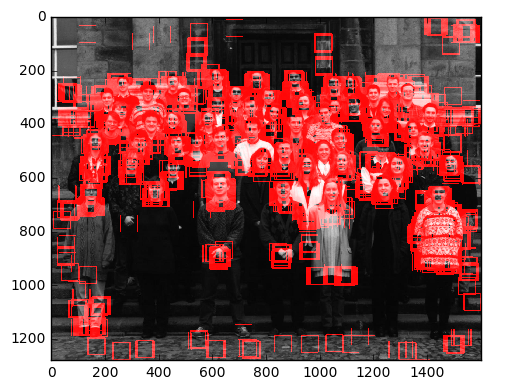

In [173]:
from skimage.util import view_as_windows, view_as_blocks

testimg = imread('hw4/class.jpg', flatten=True)
result_coords = [] 
# print(testimg.shape)
# row = 5

# print(testimg.shape)


# print(winds[0].shape)
# shape = winds.shape
# fstdim = winds.shape[0]*winds.shape[1]
# winds = winds.reshape((fstdim, 64, 64))

winds = view_as_windows(testimg, (64,64))
for i in range(winds.shape[0]):
    wind_dt = normalize(wind_dt)
    wind_dt = arr_to_integral(winds[i])
    p = casc.predict(wind_dt)
    xs = np.argwhere(p==1).flatten()
    coords = [(x, i) for x in xs]
    result_coords += coords
    
import skimage
import matplotlib.cm as cm
%matplotlib inline

result_coords_new = result_coords

modimg = np.copy(testimg)
modimg = skimage.color.gray2rgb(modimg/255)

for (x,y) in result_coords_new:
    rr,cc = skimage.draw.polygon_perimeter(
        np.array([y, y, y+63, y+63]), np.array([x, x+63, x+63, x])
    )
    modimg[rr,cc,0] = 1

skimage.io.imshow(modimg)
skimage.io.imsave('class-pred.jpg', modimg)

(16, 25, 80, 64)


/home/michbad/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


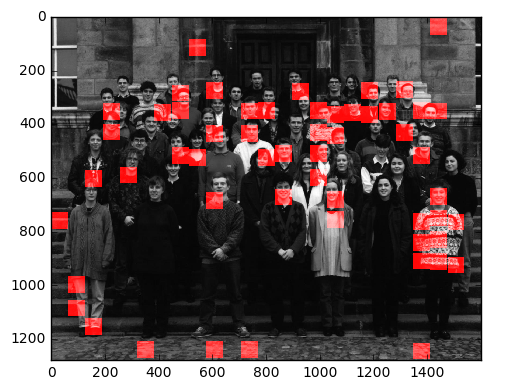

In [184]:
testimg = imread('hw4/class.jpg', flatten=True)
result_coords = [] 

# Attepmpted to remove overlapping detections, but doesn't work too well.

winds = view_as_blocks(testimg, (80, 64))
print(winds.shape)
for i in range(winds.shape[0]):
    for j in range(winds.shape[1]):
        block = np.ascontiguousarray(winds[i, j])
        wind_dt = view_as_windows(block, (64,64)).reshape((17, 64, 64))
        wind_dt = normalize(wind_dt)
        wind_dt = arr_to_integral(wind_dt)
        lol = casc.predict(wind_dt)
        p = casc.predict_raw(wind_dt)
        if np.any(p > 0):
            pos = np.argmax(p)
            x = pos // 64
            y = pos % 64
            result_coords.append((80*i+y, 64*j+x))

import skimage
import matplotlib.cm as cm
%matplotlib inline

result_coords_new = result_coords

modimg = np.copy(testimg)
modimg = skimage.color.gray2rgb(modimg/255)

for (x,y) in result_coords_new:
    rr,cc = skimage.draw.polygon(
        np.array([x, x+63, x+63, x]), np.array([y, y, y+63, y+63])
    )
    modimg[rr,cc,0] = 1

skimage.io.imshow(modimg)
skimage.io.imsave('class-pred-no-overlap.jpg', modimg)


    